In [22]:
import os
os.environ['OMP_NUM_THREADS']='16'
import dmd
import matplotlib.pyplot as plt
import numpy as np
import timeit
from scipy.linalg import pinv
from scipy.stats import linregress
from scipy.integrate import solve_ivp
import pysindy as ps
import matplotlib as mpl
colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]
tcmap=mpl.colormaps['twilight'].copy()
rcmap=mpl.colormaps['Spectral'].copy()
for key in rcmap._segmentdata.keys():
    rcmap._segmentdata[key][:,0] = np.flip(rcmap._segmentdata[key][:,0],axis=0)
    rcmap._segmentdata[key]=np.flip(rcmap._segmentdata[key],axis=0)

In [31]:
filebase0='data/cgledmd2/'
filesuffix='0'
filebase=filebase0+filesuffix
file=open(filebase0+'.out')
tskip=1
xskip=1

dat=file.readlines()
print(dat[0])
print(dat[-1])
Nx=int(dat[1].split()[0])
dx=float(dat[1].split(' ')[3])/Nx
T=float(dat[1].split(' ')[8])
dt=float(dat[1].split(' ')[11])*tskip
nx=Nx//xskip

./2dcgle -B 2 -C 0.8 -t 3E3 -A 1E3 -N 256 -d 1E-1 -v -L 50 data/cgledmd2/ 

runtime: 32.631065



In [32]:
data=np.fromfile(filebase0+'phases.dat',dtype=np.complex128).reshape((-1,Nx,Nx))[::tskip,::xskip,::xskip]
X=np.array([np.real(data),np.imag(data)]).transpose(1,0,2,3).reshape(-1,nx*nx*2)
del data

(20002, 131072)


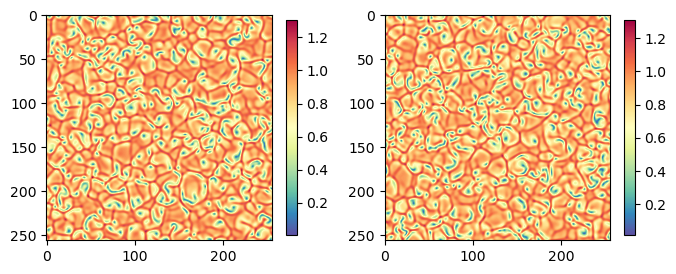

In [33]:
print(X.shape)
plt.subplots(1,2,figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(np.sqrt(X[0,:nx**2]**2+X[0,nx**2:2*nx**2]**2).reshape((nx,nx)),cmap=rcmap)
plt.colorbar(shrink=0.7)
plt.subplot(1,2,2)
plt.imshow(np.sqrt(X[-1,:nx**2]**2+X[-1,nx**2:2*nx**2]**2).reshape((nx,nx)),cmap=rcmap)
plt.colorbar(shrink=0.7)
plt.show()

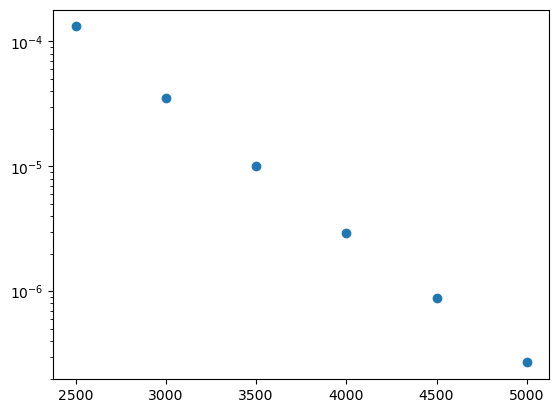

In [34]:
ranks,errs=np.load(filebase+'errs.npy')
plt.scatter(ranks,errs)
plt.yscale('log')

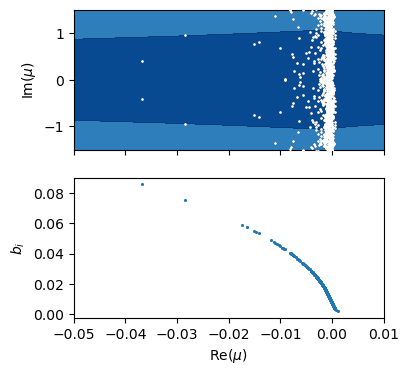

In [35]:
pseudo=np.load(filebase+'pseudo.npy')
zs=np.load(filebase+'zs.npy')
bs=np.load(filebase+'bs.npy')
evals=np.load(filebase+'evals.npy')
res=np.load(filebase+'res.npy')

resmin=1E-3
rescrit=1E-4
resmax=1E-8
levels=-np.log(resmin)/np.log(10)+(-np.log(resmax)/np.log(10)+np.log(resmin)/np.log(10))*np.arange(6)/5
inds=np.where(res<rescrit)[0]
inds=np.intersect1d(inds,np.where(np.real(np.log(evals)/dt)<0.01)[0])

plt.subplots(2,1,figsize=(4,4))
plt.subplot(2,1,1)
plt.scatter(np.real(np.log(evals)/dt),np.imag(np.log(evals)/dt),c='black',s=1,zorder=4)
plt.scatter(np.real(np.log(evals[inds])/dt),np.imag(np.log(evals[inds])/dt),c='w',s=1,zorder=4)
cs1 = plt.gca().tricontourf(np.real(np.log(zs)/dt),np.imag(np.log(zs)/dt),np.log(1/np.array(pseudo))/np.log(10),levels=levels,cmap='Blues',extend='max')
cs2 = plt.gca().tricontour(cs1,levels=levels,colors=('k',),linewidths=0.1)

# plt.xlim(-0.1,0.05)
plt.xlim(-0.05,0.01)
# plt.ylim(-np.pi,np.pi)
plt.ylim(-1.5,1.5)

plt.gca().set_xticklabels([])
plt.ylabel('$\mathrm{Im}(\mu)$')
plt.subplot(2,1,2)
plt.ylabel('$b_i$')
plt.xlabel('$\mathrm{Re}(\mu)$')
plt.scatter(np.real(np.log(evals[inds])/dt),np.abs(bs[0,inds]),s=1,zorder=4)
plt.xlim(-0.05,0.01)


plt.show()

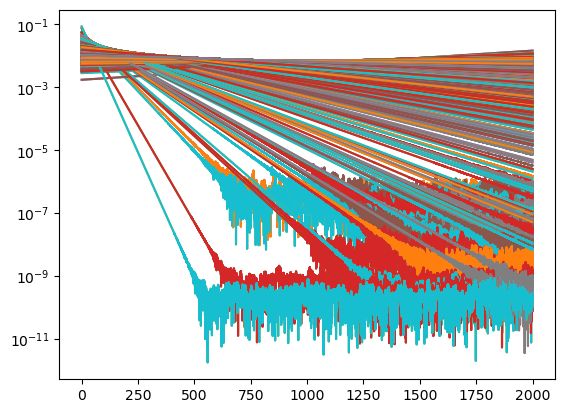

In [36]:
phitildes=np.load('%sphitildes.npy'%(filebase))
X_reconstruct=(bs[0,inds]*phitildes[inds,:2*nx**2].T).dot(evals[inds,np.newaxis]**np.arange(len(bs))[np.newaxis,:]).T.real
del phitildes
plt.plot(dt*np.arange(len(bs)),np.abs(bs[:,inds]))
plt.yscale('log')

20002


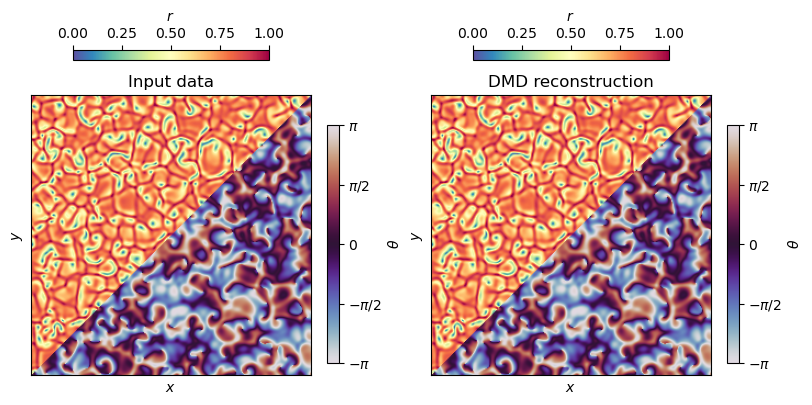

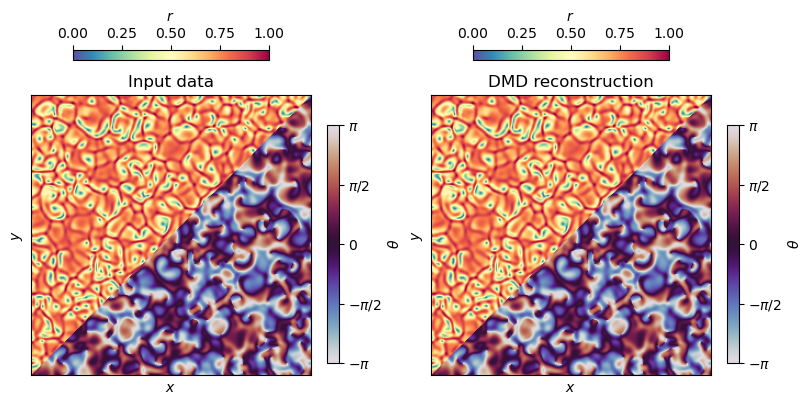

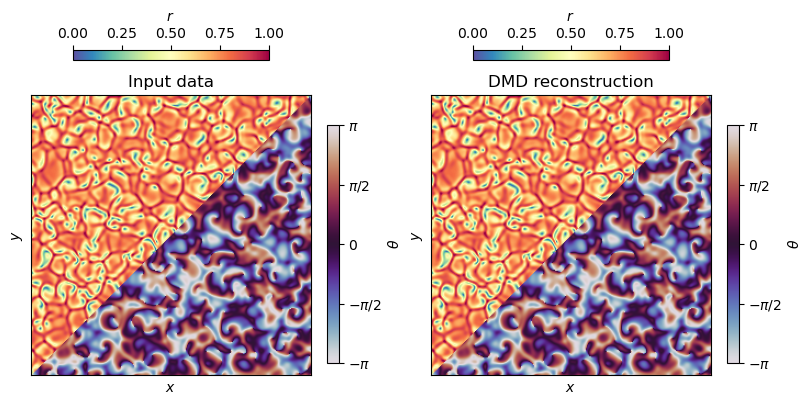

In [37]:
import matplotlib as mpl
skip=10

def makeplot(n, save=True, show=False):
    fig,ax=plt.subplots(1,2,figsize=(8,4),layout='constrained')
    plt.subplot(1,2,1)
    data=(X[skip*n,:nx*nx]+1j*X[skip*n,nx*nx:2*nx*nx]).reshape((nx,nx))
    im1=np.tril(rcmap(np.abs(data)/1.2).transpose((2,0,1)))
    im2=np.triu(tcmap((np.angle(data)+np.pi)/(2*np.pi)).transpose((2,0,1)),k=1)
    im=(im1+im2).transpose(1,2,0)
    plt.imshow(np.flip(im,axis=0))
    plt.title('Input data')
    cb1=plt.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=tcmap),ax=plt.gca(),anchor=(-1,0.5),shrink=0.8,ticks=[0,0.25,0.5,0.75,1.0],label=r'$\theta$')
    cb2=plt.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=rcmap),ax=plt.gca(),location='top',anchor=(0.5,0),shrink=0.7,label=r'$r$')
    cb1.ax.set_yticklabels(['$-\pi$','$-\pi/2$',0,'$\pi/2$','$\pi$'])
    plt.xlabel('$x$')
    plt.ylabel('$y$')

    plt.xticks([])
    plt.yticks([])

    plt.subplot(1,2,2)
    data=(X_reconstruct[skip*n,:nx*nx]+1j*X_reconstruct[skip*n,nx*nx:2*nx*nx]).reshape((nx,nx))
    im1=np.tril(rcmap(np.abs(data)/1.2).transpose((2,0,1)))
    im2=np.triu(tcmap((np.angle(data)+np.pi)/(2*np.pi)).transpose((2,0,1)),k=1)
    im=(im1+im2).transpose(1,2,0)
    plt.imshow(np.flip(im,axis=0))
    plt.title('DMD reconstruction')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.xticks([])
    plt.yticks([])
    cb1=plt.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=tcmap),ax=plt.gca(),anchor=(-1,0.5),shrink=0.8,ticks=[0,0.25,0.5,0.75,1.0],label=r'$\theta$')
    cb2=plt.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=rcmap),ax=plt.gca(),location='top',anchor=(0.5,0),shrink=0.7,label=r'$r$')
    cb1.ax.set_yticklabels(['$-\pi$','$-\pi/2$',0,'$\pi/2$','$\pi$'])
    
    if save:
        plt.savefig(filebase+'animation/%04d.png'%n)
    if show:
        plt.show()
    plt.close(fig)
print(len(X))
makeplot(0,save=False,show=True)
makeplot(((len(X))//skip-1)//2,save=False,show=True)
makeplot((len(X))//skip-1,save=False,show=True)

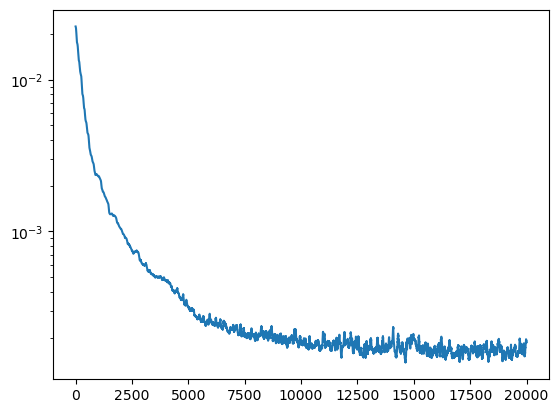

In [38]:
errs=np.linalg.norm(X[:-1]-X_reconstruct,axis=(1))/np.linalg.norm(X[:-1],axis=(1))
plt.plot(errs)
plt.yscale('log')

In [29]:
import multiprocessing
if not os.path.exists(filebase+'animation'):
    os.mkdir(filebase+'animation')
else:
    os.system('rm %sanimation/*'%(filebase))
nt=len(X)//skip
start=timeit.default_timer()
pool = multiprocessing.Pool(16,maxtasksperchild=1)
pool.map(makeplot, range(nt))
pool.close()
stop=timeit.default_timer()
print(stop-start)

101.03285794402473


In [30]:
from IPython.display import Video,display
os.system('ffmpeg -y -r 30 -i %s'%(filebase)+'animation/%04d.png -c:v libx264 -crf 1 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2,format=yuv420p" '+'%sanimation.mp4'%(filebase))
display(Video(filebase+'animation.mp4',width=512))

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


In [19]:
tot=0
mem=0
for key in globals().keys():
    if key[0] != '_':
        if isinstance(globals()[key],np.ndarray):
            mem=np.prod(globals()[key].shape)*globals()[key].dtype.itemsize/1024/1024/1024
            print(key,mem)
            tot=tot+mem
print(tot)

X 19.533203125
ranks 4.470348358154297e-08
errs 0.00014901906251907349
pseudo 5.036592483520508e-06
zs 1.0073184967041016e-05
bs 1.4901906251907349
evals 7.450580596923828e-05
res 3.725290298461914e-05
levels 4.470348358154297e-08
inds 1.2442469596862793e-05
X_reconstruct 19.5322265625
40.55590873211622
